<a href="https://colab.research.google.com/github/tfredrick112/CatDog/blob/master/CatDog_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!nvidia-smi

Thu Jan  9 06:51:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    24W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Unzip the file from Google Drive and load it into Colab

In [0]:
!unzip -uq "/content/drive/My Drive/datasets/catdog/train.zip" -d "/content/catdog"
!unzip -uq "/content/drive/My Drive/datasets/catdog/test1.zip" -d "/content/catdog"

In [0]:
# I want to check the number of files in these folders.
import os
print("Number of files in /content/catdog/train : ", len(os.listdir("/content/catdog/train")))
print("Number of files in /content/catdog/test1 : ", len(os.listdir("/content/catdog/test1")))

Number of files in /content/catdog/train :  25000
Number of files in /content/catdog/test1 :  12500


To see some of the dog images in our training set

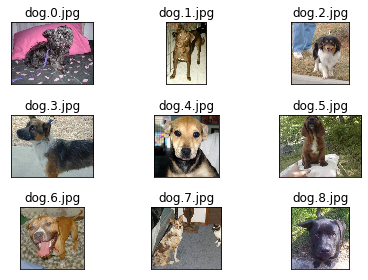

In [0]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

folder = 'catdog/train/'
for i in range(9):
  plt.subplot(3, 3, i + 1)
  plt.xticks([])
  plt.yticks([])
  filename = 'dog.' + str(i) + '.jpg'
  image = imread(folder + filename)
  plt.imshow(image)
  plt.title(filename)
plt.tight_layout()

To see some of the cat images in our training set

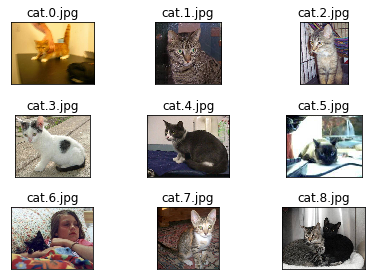

In [0]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

folder = 'catdog/train/'
for i in range(9):
  plt.subplot(3, 3, i + 1)
  plt.xticks([])
  plt.yticks([])
  filename = 'cat.' + str(i) + '.jpg'
  image = imread(folder + filename)
  plt.imshow(image)
  plt.title(filename)
plt.tight_layout()

In order to be able to use the ImageDataGenerator of Keras, the data must be stored in separate directories for each class.


In [0]:
# files = os.listdir('/content/dataset_dogs_vs_cats/train/dogs')
# print(len(files))
# for each in files:
#   os.remove('/content/dataset_dogs_vs_cats/train/dogs/'+each)

In [0]:
# organize dataset into a useful structure
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random
# create directories
dataset_home = 'dataset_dogs_vs_cats/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
	# create label subdirectories
	labeldirs = ['dogs/', 'cats/']
	for labldir in labeldirs:
		newdir = dataset_home + subdir + labldir
		makedirs(newdir, exist_ok=True)
# seed random number generator
seed(1)
# define ratio of pictures to use for validation
val_ratio = 0.25
# copy training dataset images into subdirectories
src_directory = '/content/catdog/train/'
for file in listdir(src_directory):
	src = src_directory + '/' + file
	dst_dir = 'train/'
	if random() < val_ratio:
		dst_dir = 'test/'
	if file.startswith('cat'):
		dst = dataset_home + dst_dir + 'cats/'  + file
		copyfile(src, dst)
	elif file.startswith('dog'):
		dst = dataset_home + dst_dir + 'dogs/'  + file
		copyfile(src, dst)

In [0]:
print("Number of files in /dataset_dogs_vs_cats/train/cats : ", len(os.listdir("/content/dataset_dogs_vs_cats/train/cats")))
print("Number of files in /dataset_dogs_vs_cats/train/dogs : ", len(os.listdir("/content/dataset_dogs_vs_cats/train/dogs")))
print("Number of files in /dataset_dogs_vs_cats/test/cats : ", len(os.listdir("/content/dataset_dogs_vs_cats/test/cats")))
print("Number of files in /dataset_dogs_vs_cats/test/dogs : ", len(os.listdir("/content/dataset_dogs_vs_cats/test/dogs")))

Number of files in /dataset_dogs_vs_cats/train/cats :  9352
Number of files in /dataset_dogs_vs_cats/train/dogs :  9345
Number of files in /dataset_dogs_vs_cats/test/cats :  3148
Number of files in /dataset_dogs_vs_cats/test/dogs :  3155


### Building a baseline CNN model

In [0]:
import sys
from keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout
from keras.models import Sequential
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

Using TensorFlow backend.


In [0]:
# define the baseline CNN model
# This is a one block baseline model(VGG1)
def define_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(1, activation='sigmoid'))
  opt = SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer = opt, loss='binary_crossentropy', metrics = ['accuracy'])
  return model


# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['acc'], color='blue', label='train')
	plt.plot(history.history['val_acc'], color='orange', label='test')
	plt.tight_layout()

In [0]:
def run_test_harness():
  model = define_model()
  datagen = ImageDataGenerator(rescale=1.0/255.0)
  train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
                                         class_mode='binary',
                                         batch_size=64,
                                         target_size=(200, 200))
  test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
                                        class_mode='binary',
                                        batch_size=64,
                                        target_size=(200, 200))
  # now fit the model
  history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
                      validation_data=test_it, validation_steps=len(test_it),
                      epochs=20, verbose=2)
  
  _, accuracy = model.evaluate_generator(test_it, steps=len(test_it), verbose=2)
  print("Accuracy of the model: ", round(accuracy * 100.0,3))
  summarize_diagnostics(history)

Let us check the results of the VGG model with only one block.

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
Epoch 1/20
 - 68s - loss: 0.6855 - acc: 0.5652 - val_loss: 0.6468 - val_acc: 0.6189
Epoch 2/20
 - 66s - loss: 0.6453 - acc: 0.6193 - val_loss: 0.6402 - val_acc: 0.6175
Epoch 3/20
 - 66s - loss: 0.6461 - acc: 0.5963 - val_loss: 0.6229 - val_acc: 0.6462
Epoch 4/20
 - 66s - loss: 0.6193 - acc: 0.6468 - val_loss: 0.6272 - val_acc: 0.6297
Epoch 5/20
 - 66s - loss: 0.6115 - acc: 0.6551 - val_loss: 0.6078 - val_acc: 0.6619
Epoch 6/20
 - 66s - loss: 0.5986 - acc: 0.6678 - val_loss: 0.6249 - val_acc: 0.6270
Epoch 7/20
 - 66s - loss: 0.5893 - acc: 0.6747 - val_loss: 0.6052 - val_acc: 0.6606
Epoch 8/20
 - 65s - loss: 0.5684 - acc: 0.6989 - val_loss: 0.5845 - val_acc: 0.6782
Epoch 9/20
 - 66s - loss: 0.5550 - acc: 0.7106 - val_loss: 0.5755 - val_acc: 0.6952
Epoch 10/20
 - 66s - loss: 0.5289 - acc: 0.7352 - val_loss: 0.5698 - val_acc: 0.7032
Epoch 11/20
 - 66s - loss: 0.5039 - acc: 0.7570 - val_loss: 0.5568 - val_a

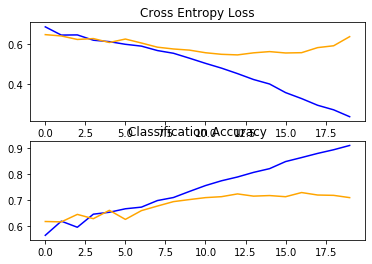

In [0]:
run_test_harness()

Using the VGG 1 model, we have obtained 71.06% accuracy on the validation dataset. We notice that starting from epoch 11, the model begins to suffer from overfitting as the training accuracy keeps increasing, but the validation accuracy saturates and also begins to decrease slowly.

Let us now see what happens when we use a VGG model with two blocks.

In [0]:
def define_model_2():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same',input_shape=(200, 200, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(1, activation='sigmoid'))

  opt = SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

def run_test_harness_2():
  model = define_model_2()
  datagen = ImageDataGenerator(rescale=1.0/255.0)
  train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
                                         class_mode='binary',
                                         batch_size=64,
                                         target_size=(200, 200))
  test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
                                        class_mode='binary',
                                        batch_size=64,
                                        target_size=(200, 200))
  # now fit the model
  history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
                      validation_data=test_it, validation_steps=len(test_it),
                      epochs=20, verbose=2)
  
  _, accuracy = model.evaluate_generator(test_it, steps=len(test_it), verbose=2)
  print("Accuracy of the model: ", round(accuracy * 100.0,3))
  summarize_diagnostics(history)

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
Epoch 1/20
 - 70s - loss: 0.6843 - acc: 0.5646 - val_loss: 0.6697 - val_acc: 0.5807
Epoch 2/20
 - 67s - loss: 0.6444 - acc: 0.6180 - val_loss: 0.6271 - val_acc: 0.6424
Epoch 3/20
 - 67s - loss: 0.6186 - acc: 0.6466 - val_loss: 0.6192 - val_acc: 0.6529
Epoch 4/20
 - 67s - loss: 0.5910 - acc: 0.6781 - val_loss: 0.5991 - val_acc: 0.6629
Epoch 5/20
 - 67s - loss: 0.5559 - acc: 0.7170 - val_loss: 0.5722 - val_acc: 0.7009
Epoch 6/20
 - 67s - loss: 0.5248 - acc: 0.7415 - val_loss: 0.5304 - val_acc: 0.7327
Epoch 7/20
 - 67s - loss: 0.4881 - acc: 0.7679 - val_loss: 0.5244 - val_acc: 0.7357
Epoch 8/20
 - 67s - loss: 0.4515 - acc: 0.7880 - val_loss: 0.5309 - val_acc: 0.7276
Epoch 9/20
 - 67s - loss: 0.4220 - acc: 0.8084 - val_loss: 0.5552 - val_acc: 0.7192
Epoch 10/20
 - 67s - loss: 0.3996 - acc: 0.8216 - val_loss: 0.5022 - val_acc: 0.7554
Epoch 11/20
 - 67s - loss: 0.3627 - acc: 0.8402 - val_loss: 0.5395 - val_a

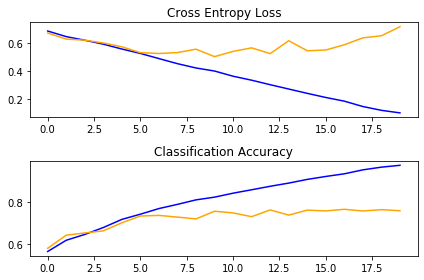

In [0]:
run_test_harness_2()

We see an improvement in the validation accuracy. The new accuracy is 75.77%. However, overfitting sets in within the 6th epoch itself, after which there is just a saturation 

In [0]:
def define_model_3():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same',input_shape=(200, 200, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(1, activation='sigmoid'))

  opt = SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

def run_test_harness_3():
  model = define_model_3()
  datagen = ImageDataGenerator(rescale=1.0/255.0)
  train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
                                         class_mode='binary',
                                         batch_size=64,
                                         target_size=(200, 200))
  test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
                                        class_mode='binary',
                                        batch_size=64,
                                        target_size=(200, 200))
  # now fit the model
  history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
                      validation_data=test_it, validation_steps=len(test_it),
                      epochs=20, verbose=2)
  
  _, accuracy = model.evaluate_generator(test_it, steps=len(test_it), verbose=2)
  print("Accuracy of the model: ", round(accuracy * 100.0,3))
  summarize_diagnostics(history)

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
Epoch 1/20
 - 71s - loss: 0.6595 - acc: 0.6042 - val_loss: 0.6140 - val_acc: 0.6641
Epoch 2/20
 - 69s - loss: 0.5931 - acc: 0.6787 - val_loss: 0.5853 - val_acc: 0.6879
Epoch 3/20
 - 69s - loss: 0.5564 - acc: 0.7137 - val_loss: 0.5447 - val_acc: 0.7308
Epoch 4/20
 - 68s - loss: 0.5193 - acc: 0.7427 - val_loss: 0.5372 - val_acc: 0.7265
Epoch 5/20
 - 69s - loss: 0.4821 - acc: 0.7711 - val_loss: 0.5152 - val_acc: 0.7468
Epoch 6/20
 - 69s - loss: 0.4531 - acc: 0.7881 - val_loss: 0.4916 - val_acc: 0.7628
Epoch 7/20
 - 69s - loss: 0.4244 - acc: 0.8034 - val_loss: 0.4748 - val_acc: 0.7725
Epoch 8/20
 - 68s - loss: 0.3930 - acc: 0.8242 - val_loss: 0.4703 - val_acc: 0.7752
Epoch 9/20
 - 69s - loss: 0.3713 - acc: 0.8352 - val_loss: 0.5114 - val_acc: 0.7587
Epoch 10/20
 - 69s - loss: 0.3399 - acc: 0.8526 - val_loss: 0.4737 - val_acc: 0.7782
Epoch 11/20
 - 69s - loss: 0.3119 - acc: 0.8681 - val_loss: 0.4629 - val_a

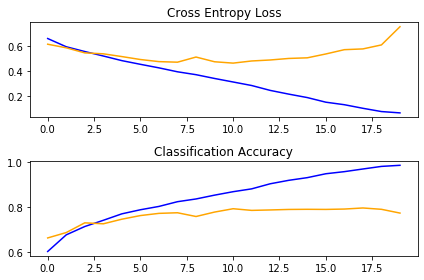

In [0]:
run_test_harness_3()

There is an improvement in the accuracy, now the model gets 77.38%. However overfitting is also increasing too early in this case. Note that in epoch 19 and some preceding cakes, the accuracy
79.04%.

#### Dropout Regularization

We will add a small value of dropout regularization to the Conv2D layer blocks and a larger amount to the dense or fully connected layer of the VGG3 model. The addition of the dropout regularization layer helps us prevent overfitting. I increased the number of epochs because I want to give the model more time to train all these layers.

In [0]:
def define_model_reg():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same',input_shape=(200, 200, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))

  opt = SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

def run_test_harness_reg():
  model = define_model_reg()
  datagen = ImageDataGenerator(rescale=1.0/255.0)
  train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
                                         class_mode='binary',
                                         batch_size=64,
                                         target_size=(200, 200))
  test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
                                        class_mode='binary',
                                        batch_size=64,
                                        target_size=(200, 200))
  # now fit the model
  history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
                      validation_data=test_it, validation_steps=len(test_it),
                      epochs=50, verbose=2)
  
  _, accuracy = model.evaluate_generator(test_it, steps=len(test_it), verbose=2)
  print("Accuracy of the model: ", round(accuracy * 100.0,3))
  summarize_diagnostics(history)

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
Epoch 1/50
 - 73s - loss: 1.2682 - acc: 0.5347 - val_loss: 0.6815 - val_acc: 0.5832
Epoch 2/50
 - 70s - loss: 0.6681 - acc: 0.5858 - val_loss: 0.6638 - val_acc: 0.6096
Epoch 3/50
 - 70s - loss: 0.6474 - acc: 0.6101 - val_loss: 0.6596 - val_acc: 0.5929
Epoch 4/50
 - 71s - loss: 0.6291 - acc: 0.6361 - val_loss: 0.6244 - val_acc: 0.6552
Epoch 5/50
 - 70s - loss: 0.6092 - acc: 0.6638 - val_loss: 0.6041 - val_acc: 0.6732
Epoch 6/50
 - 70s - loss: 0.5909 - acc: 0.6834 - val_loss: 0.5853 - val_acc: 0.6898
Epoch 7/50
 - 70s - loss: 0.5748 - acc: 0.6969 - val_loss: 0.5715 - val_acc: 0.6960
Epoch 8/50
 - 70s - loss: 0.5587 - acc: 0.7113 - val_loss: 0.5612 - val_acc: 0.7130
Epoch 9/50
 - 69s - loss: 0.5426 - acc: 0.7244 - val_loss: 0.5512 - val_acc: 0.7059
Epoch 10/50
 - 70s - loss: 0.5331 - acc: 0.7333 - val_loss: 0.5408 - val_acc: 0.7314
Epoch 11/50
 - 70s - loss: 0.5195 - acc: 0.7400 - val_loss: 0.5310 - val_a

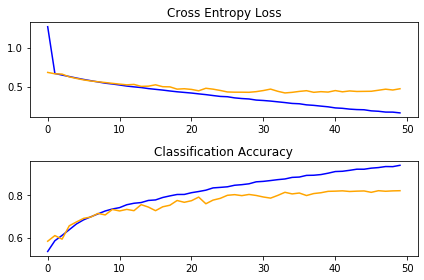

In [0]:
run_test_harness_reg()

After adding Dropout regularization, our validation accuracy has increased to 81. 882%. We can also see that the model shows signs of overfitting only after around epoch 13. Till that point, the training accuracy and the validation accuracy increase together. After that, the training accuracy continues to increase, but the validation accuracy begins to saturate.

It is important to notice that even after 50 epochs, the training set accuracy is around 93%, as opposed to the ~98% value that was obtained by the VGG 3 model(without dropout regularization). This shows that the use of dropout has prevented the model from learning features very specific to the training set. The increase in validation accuracy as compared to the VGG 3 model indicates that the model is now able to generalize better.

#### Data Augmentation

We will first use the VGG3 model without dropout and see what happens when we use image data augmentation.


In [0]:
def run_test_harness_aug():
  model = define_model_3()
  # separate data generators for training and validation
  # as data aug has to be applied only to the training set
  train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     horizontal_flip=True)
  test_datagen = ImageDataGenerator(rescale=1.0/255.0)

  train_it = train_datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
                                         class_mode='binary',
                                         batch_size=64,
                                         target_size=(200, 200))
  test_it = test_datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
                                        class_mode='binary',
                                        batch_size=64,
                                        target_size=(200, 200))
  # now fit the model
  history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
                      validation_data=test_it, validation_steps=len(test_it),
                      epochs=50, verbose=2)
  
  _, accuracy = model.evaluate_generator(test_it, steps=len(test_it), verbose=2)
  print("Accuracy of the model: ", round(accuracy * 100.0,3))
  return history
  

In [0]:
history = run_test_harness_aug()
summarize_diagnostics(history)

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
Epoch 1/50
 - 211s - loss: 0.6775 - acc: 0.5732 - val_loss: 0.6360 - val_acc: 0.6418
Epoch 2/50
 - 196s - loss: 0.6428 - acc: 0.6264 - val_loss: 0.6094 - val_acc: 0.6697
Epoch 3/50
 - 194s - loss: 0.6160 - acc: 0.6577 - val_loss: 0.5735 - val_acc: 0.7040
Epoch 4/50
 - 193s - loss: 0.5954 - acc: 0.6786 - val_loss: 0.5491 - val_acc: 0.7274
Epoch 5/50
 - 193s - loss: 0.5671 - acc: 0.7050 - val_loss: 0.5342 - val_acc: 0.7298
Epoch 6/50
 - 193s - loss: 0.5490 - acc: 0.7208 - val_loss: 0.5161 - val_acc: 0.7433
Epoch 7/50
 - 193s - loss: 0.5352 - acc: 0.7273 - val_loss: 0.5035 - val_acc: 0.7522
Epoch 8/50
 - 193s - loss: 0.5215 - acc: 0.7402 - val_loss: 0.4896 - val_acc: 0.7658
Epoch 9/50
 - 193s - loss: 0.5050 - acc: 0.7544 - val_loss: 0.5172 - val_acc: 0.7449
Epoch 10/50
 - 193s - loss: 0.4941 - acc: 0.7632 - val_loss: 0.4726 - val_acc: 0.7742
Epoch 11/50
 - 193s - loss: 0.4834 - acc: 0.7673 - val_loss: 0.4

NameError: ignored

With the help of data augmentation, we have obtained a validation accuracy = 85.562%. 

## Transfer learning

I am going to use the VGG-16 model. This model expects input images of the shape (224, 224, 3).

The VGG 16 model also expects the images to be centred. This means that the mean pixel values for each channel as calculated on the ImageNet dataset must be subtracted from each pixel value of every image in our dataset also.

In [0]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
import matplotlib.pyplot as plt

def define_model_transfer():
  # first load the VGG 16 model, remember to use include_top=False
  model = VGG16(include_top=False, input_shape=(224, 224, 3))
  # mark the loaded layers as non-trainable
  for layer in model.layers:
    layer.trainable = False
  
  flat1 = Flatten()(model.layers[-1].output)
  class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
  output = Dense(1, activation='sigmoid')(class1)

  model = Model(inputs = model.inputs, outputs=output)
  opt = SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

def run_test_transfer():
  model = define_model_transfer()
  datagen = ImageDataGenerator(featurewise_center=True)
  # I am specifying the channel means of ImageNet for centering
  datagen.mean = [123.68, 116.779, 103.939]

  train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
                                         batch_size=64,
                                         target_size=(224, 224),
                                         class_mode='binary')
  test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
                                        batch_size=64,
                                        target_size=(224, 224),
                                        class_mode='binary')
  
  history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
                                epochs=10, validation_data=test_it,
                                validation_steps=len(test_it), verbose=2)
  
  _, accuracy = model.evaluate_generator(test_it, steps=len(test_it), verbose=2)
  print("Accuracy of the model: {}".format(round(accuracy*100.0, 3)))
  return history

In [0]:
history = run_test_transfer()



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.


Epoch 1/10
 - 114s - loss: 0.5351 - acc: 0.9584 - val_loss: 0.3005 - val_acc: 0.9745
Epoch 2/10
 - 103s - loss: 0.1494 - acc: 0.9767 - val_loss: 0.0773 - val_acc: 0.9719
Epoch 3/10
 - 103s - loss: 0.0381 - acc: 0.9895 - val_loss: 0.0781 - val_acc: 0.9743
Epoch 4/10
 - 102s - loss: 0.0155 - acc: 0.9967 - val_loss: 0.0835 - val_acc: 0.9746
Epoch 5/10
 - 101s - loss: 0.0071 - acc: 0.9989 - val_loss: 0.0952 - val_acc: 0.9743
Epoch 6/10
 - 101s - loss: 0.0051 - acc: 0.9996 - val_loss: 0.1039 - val_acc: 0.9729
Epoch 7/10
 - 99s - loss: 0.0044 - acc: 0.9996 - val_loss: 0.1072 - val_acc: 0.9735
Epoch 8/10
 - 100s - loss: 0.0042 - acc: 0.9996 - val_loss: 0.1101 - val_acc: 0.9738
Epoch 9/10
 - 101s - loss: 0.0040 - acc: 0.9997 - val_loss: 0.1135 - val_acc: 0.9737
Epoch 10/10
 - 100s - loss: 0.0038 - acc: 0.9997 - va

Using transfer learning, I have obtained an accuracy of 97.366%. 

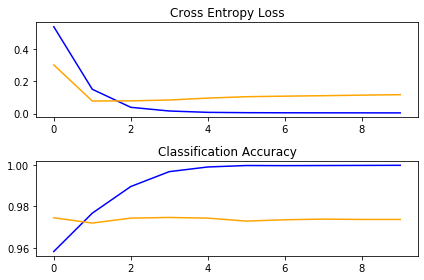

In [0]:
summarize_diagnostics(history)

## Preparing the final training set

I have finalized the model, I will be using the feature extraction layers of the VGG-16 modefollowed by a fully connected layer with 128 neurons and a sigmoid layer with one neuron for the final classification.

Moreover, for the final step the model must be trained on the complete training dataset, without any of the previously used 25% partition.

In [0]:
from os import listdir, makedirs
from shutil import copyfile

dataset_home = 'final_dataset_dogs_cats/'
label_dirs = ['cats/', 'dogs/']
for label in label_dirs:
  new_dir_name = dataset_home + label
  makedirs(new_dir_name, exist_ok=True)

source_dir = 'catdog/train/'
all_images = listdir(source_dir)
for file in all_images:
  src = source_dir + '/' + file
  if file.startswith('cat'):
    dst = dataset_home + 'cats/' + file
    copyfile(src, dst)
  elif file.startswith('dog'):
    dst = dataset_home + 'dogs/' + file
    copyfile(src, dst)

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.optimizers import SGD
from keras.applications.vgg16 import VGG16
import h5py

def define_model_transfer_final():
  model = VGG16(include_top=False, input_shape=(224, 224, 3))
  for layer in model.layers:
    layer.trainable = False
  
  flat1 = Flatten()(model.layers[-1].output)
  class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
  output1 = Dense(1, activation='sigmoid')(class1)

  model = Model(inputs=model.inputs, outputs=output1)
  opt = SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

def run_test_final():
  model = define_model_transfer_final()
  datagen = ImageDataGenerator(featurewise_center=True)
  datagen.mean = [123.68, 116.779, 103.939]
  train_it = datagen.flow_from_directory('final_dataset_dogs_cats/',
                                         batch_size=64,
                                         target_size=(224, 224),
                                         class_mode='binary')
  model.fit_generator(train_it, steps_per_epoch=len(train_it), epochs=10,
                      verbose=2)
  return model
  


In [0]:
final_model = run_test_final()

Found 25000 images belonging to 2 classes.
Epoch 1/10
 - 207s - loss: 0.4522 - acc: 0.9585
Epoch 2/10
 - 206s - loss: 0.0534 - acc: 0.9830
Epoch 3/10
 - 206s - loss: 0.0184 - acc: 0.9952
Epoch 4/10
 - 206s - loss: 0.0065 - acc: 0.9988
Epoch 5/10
 - 206s - loss: 0.0039 - acc: 0.9997
Epoch 6/10
 - 206s - loss: 0.0033 - acc: 0.9997
Epoch 7/10
 - 206s - loss: 0.0031 - acc: 0.9997
Epoch 8/10
 - 206s - loss: 0.0030 - acc: 0.9998
Epoch 9/10
 - 206s - loss: 0.0029 - acc: 0.9998
Epoch 10/10
 - 206s - loss: 0.0028 - acc: 0.9998


In [0]:
final_model.save('cats_dogs_model.h5')